# Show SOP

In this notebook, we describe how to load an existing sop model and show the groups.
We will break down into the following steps:

1. Load the model from a directory
2. Show the groups

## Load the SOP model

#### Save

In [1]:
from collections import namedtuple
import torch.nn as nn

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])

class WrappedModel(nn.Module):
    def __init__(self, model, output_type='tuple', num_patch=14, layer=-1):
        super().__init__()
        assert output_type in ['tuple', 'logits', 'hidden_states']
        self.model = model
        self.output_type = output_type
        self.num_patch = num_patch
        self.layer = layer
        
        # backbone layer - input hidden size mapping
        # layer -1 has input_hidden_size of 48
        self.bbl_ihs_mapping = {
            -1: 48,
            -2: 32,
            -3: 16
        }
    
    def forward(self, inputs):
        if self.output_type == 'tuple':
            outputs = self.model(inputs, output_hidden_states=True)
            return WrappedBackboneOutput(outputs.logits, outputs.pooler_output)
        elif self.output_type == 'logits':
            outputs = self.model(inputs)
            return outputs
        else: # hidden_states
            import pdb; pdb.set_trace()
            outputs = self.model(inputs, output_hidden_states=True)
            return outputs.hidden_states[self.layer]

In [18]:
import torch
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')

from exlib.modules.sop import SOPConfig, SOPImageCls, get_wrapped_models

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# backbone_model_name='google/vit-base-patch16-224'
sop_model_name='/shared_data0/weiqiuy/sop/notebooks/exps/cosmogrid_lr5e-06_tgtnnz0.2_gg0.0600_gs10.0000_ft_identify_fixk_scratch_ks1_segpatch_4h/best'

# # init backbone model
# backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
# processor = AutoImageProcessor.from_pretrained(backbone_model_name)
# backbone_config = AutoConfig.from_pretrained(backbone_model_name)
from exlib.datasets.mass_maps import *

# init backbone model
# backbone_model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224')
# processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
backbone_model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
backbone_model = backbone_model.to(device)
processor = None

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
config = SOPConfig(json_file=sop_model_name) # can pass in the directory path or the config.json file name. If a dir is passed, then it will automatically read the config.json file inside.
config.class_weight_layer = 'model.fc4'
config.finetune_layers[0] = 'model.fc4'
# config.__dict__.update(backbone_config.__dict__)
# config.num_labels = len(backbone_config.id2label)
# wrapped_backbone_model, class_weights, projection_layer = get_wrapped_models(backbone_model, config)

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
wrapped_backbone_model = WrappedModel(backbone_model, output_type='tuple') #TODO: make it use the correct model
projection_layer = WrappedModel(backbone_model, output_type='hidden_states', layer=-2)

# init sop
# SOP should be able to take just the wrapped backbone model and then, but then the problem is the class weights shape is unknown
model = SOPImageCls(config, wrapped_backbone_model, projection_layer=projection_layer)
if sop_model_name is not None:
    state_dict = torch.load(os.path.join(sop_model_name, 
                                    'checkpoint.pth'))
    print('Loaded step', state_dict['step'])
    model.load_state_dict(state_dict['model'], strict=False) # blackbox model doesn't match but it's ok since it's not finetuned

projection layer is not frozen
Loaded step 17101


In [19]:
model.save_pretrained('/shared_data0/weiqiuy/hf_repos/sop-massmaps-conv')

In [20]:
config = SOPConfig.from_pretrained('/shared_data0/weiqiuy/hf_repos/sop-massmaps-conv')

In [21]:
model = SOPImageCls.from_pretrained('/shared_data0/weiqiuy/hf_repos/sop-massmaps-conv', 
                                    blackbox_model=wrapped_backbone_model, projection_layer=projection_layer)

projection layer is not frozen


#### Load

In [6]:
import torch
import os
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')
from exlib.modules.sop import SOPConfig, SOPImageCls, get_chained_attr
from exlib.datasets.mass_maps import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# init backbone model
backbone_model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
backbone_model = backbone_model.to(device)
processor = None

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
wrapped_backbone_model = WrappedModel(backbone_model, output_type='tuple')
projection_layer = WrappedModel(backbone_model, output_type='hidden_states', layer=-2)

# load trained sop model
model = SOPImageCls.from_pretrained('/shared_data0/weiqiuy/hf_repos/sop-massmaps-conv', 
                                    blackbox_model=wrapped_backbone_model, 
                                    # class_weights=class_weights, 
                                    projection_layer=projection_layer)

model = model.to(device)
model.eval();

projection layer is not frozen


In [7]:
val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
val_dataset.set_format('torch', columns=['input', 'label'])

In [8]:
batch = next(iter(val_dataset))
inputs = batch['input'].to(device)[:,None]
labels = batch['label'].to(device)

In [9]:
outputs = model(inputs, return_tuple=True)

> /tmp/ipykernel_9036/3315887245.py(34)forward()
     31             return outputs
     32         else: # hidden_states
     33             import pdb; pdb.set_trace()
---> 34             outputs = self.model(inputs, output_hidden_states=True)
     35             return outputs.hidden_states[self.layer]



ipdb>  n


> /tmp/ipykernel_9036/3315887245.py(35)forward()
     31             return outputs
     32         else: # hidden_states
     33             import pdb; pdb.set_trace()
     34             outputs = self.model(inputs, output_hidden_states=True)
---> 35             return outputs.hidden_states[self.layer]



ipdb>  outputs.hidden_states[-2].shape


torch.Size([1, 32, 14, 14])


ipdb>  c


In [10]:
print('logits', outputs.logits.shape)
print('logits_all', outputs.logits_all.shape)
print('group_attributions', outputs.group_attributions.shape)

logits torch.Size([1, 2])
logits_all torch.Size([1, 20, 2])
group_attributions torch.Size([1, 20, 2])


In [15]:
from exlib.datasets.mass_maps import map_plotter

def show_masked_img(img, mask, ax):
    map_plotter(img[0].cpu().numpy(), 
                    mask.cpu().numpy(),
                   ax)

def show_masks(img, masks, titles=None, cols=5, imgsize=3):
    n_masks = len(masks)
    rows = math.ceil(n_masks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * imgsize, rows * imgsize))
    axes = axes.ravel()
    for m_i in range(len(masks)):
        mask = masks[m_i]
        show_masked_img(img, mask, axes[m_i])
        if titles is not None:
            axes[m_i].set_title(titles[m_i])
    for m_i in range(len(masks), len(axes)):
        axes[m_i].axis('off')
    plt.show()

def get_mask_weights_titles(mask_weights):
    titles = [f'{mask_weight.item():.10f}' for mask_weight in mask_weights]
    return titles

def get_masks_used(outputs, i=0, pred=0):
    # pred = outputs.logits[i].argmax(-1).item()
    pred_mask_idxs_sort = outputs.mask_weights[i,:,pred].argsort(descending=True)
    # mask_weights_sort = (outputs.mask_weights * outputs.logits_all)[i,pred_mask_idxs_sort,pred]
    mask_weights_sort = outputs.mask_weights[i,pred_mask_idxs_sort,pred]
    masks_sort = outputs.masks[i,pred_mask_idxs_sort]
    masks_sort_used = (masks_sort[mask_weights_sort != 0] != 0).int()
    mask_weights_sort_used = mask_weights_sort[mask_weights_sort != 0]
    return {
        'masks_sort_used': masks_sort_used, 
        'mask_weights_sort_used': mask_weights_sort_used
    }

def show_masks_weights(inputs, expln, pred=0):
    outputs = get_masks_used(expln, i=0, pred=pred)
    masks = outputs['masks_sort_used']
    mask_weights = outputs['mask_weights_sort_used']
    denormed_img = (inputs[0:1] + 1) / 2
    print('original')
    plt.figure()
    plt.imshow(denormed_img[0].cpu().permute(1,2,0))
    plt.show()
    print('selected masks')
    titles = get_mask_weights_titles(mask_weights)
    show_masks(denormed_img[0], masks, titles=titles)
    print('all masks')
    show_masks(denormed_img[0], expln.masks[0], cols=14)
    

Omega
original


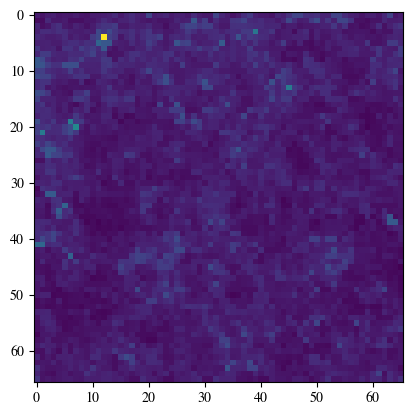

selected masks


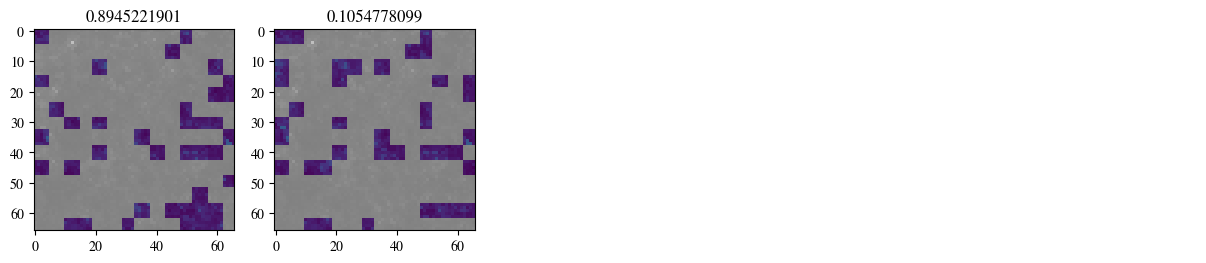

all masks


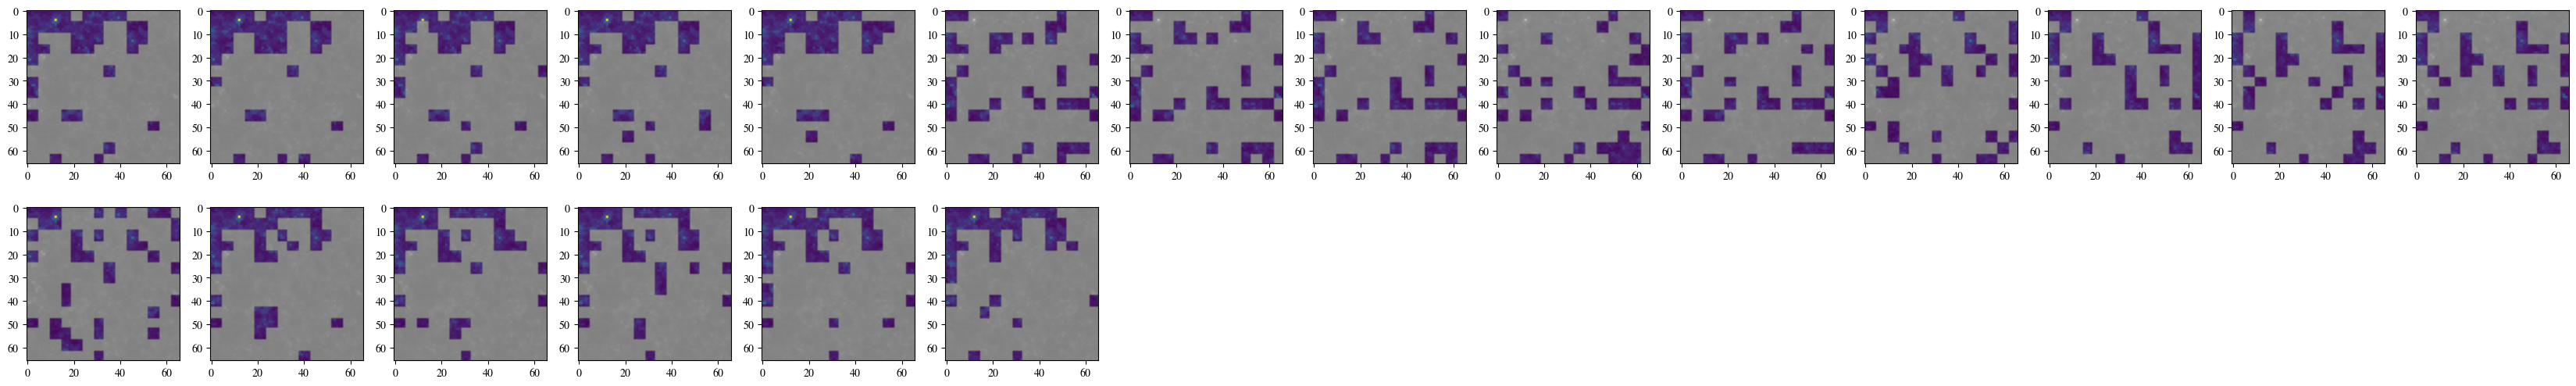

sigma
original


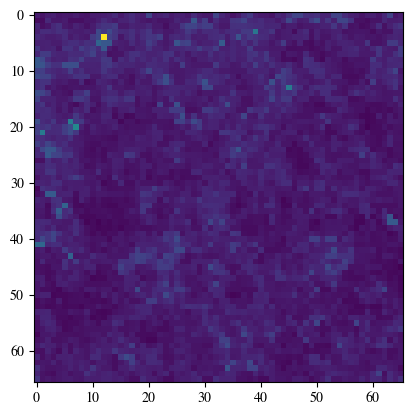

selected masks


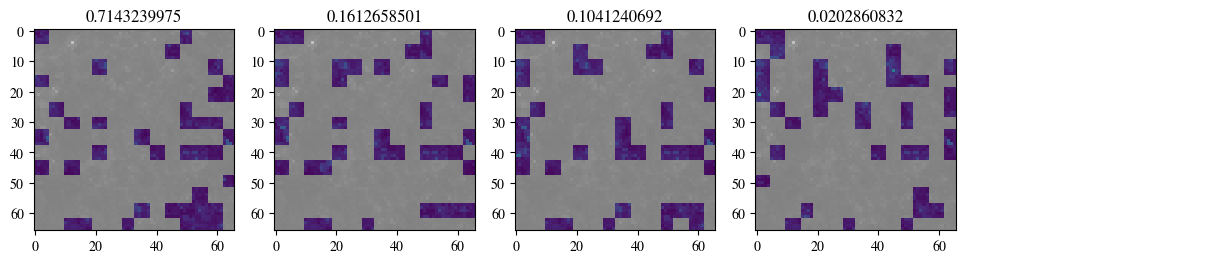

all masks


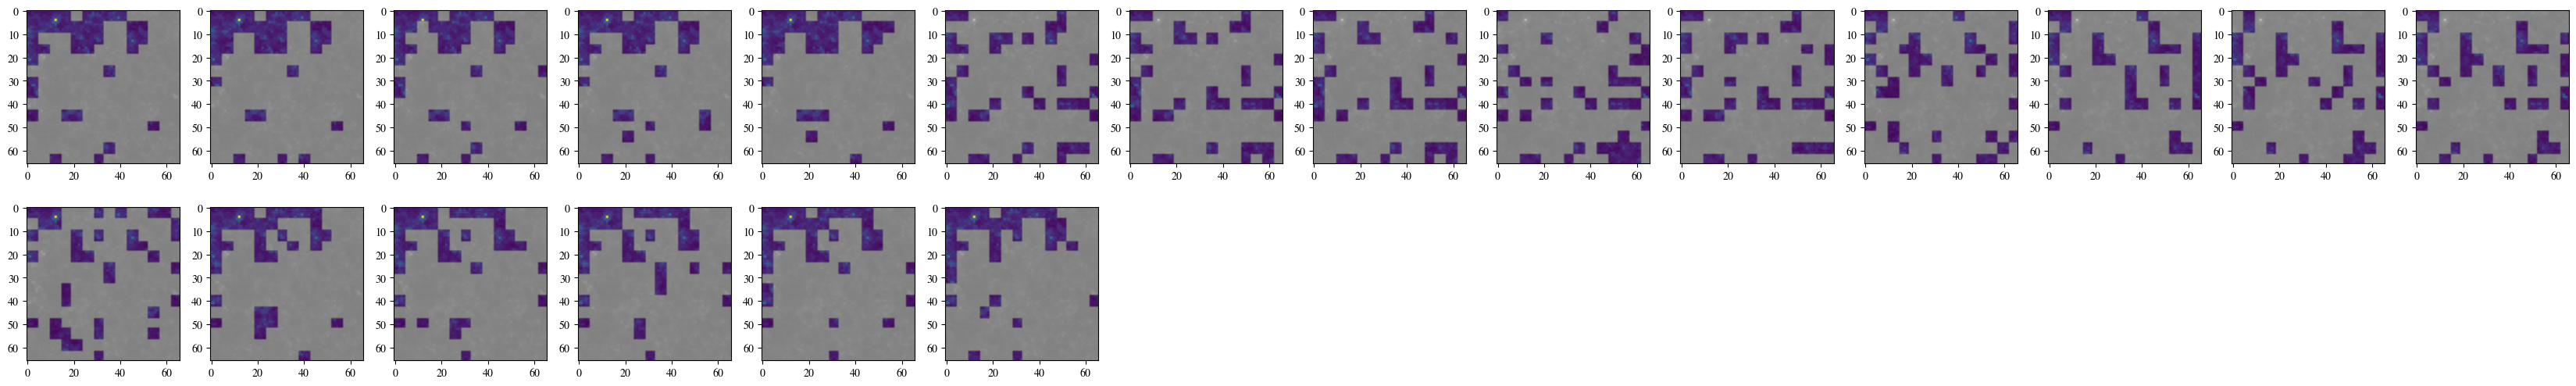

In [17]:
print('Omega')
show_masks_weights(inputs, outputs, pred=0)
print('sigma')
show_masks_weights(inputs, outputs, pred=1)

## Show the groups from SOP